### The purpose is to continue with the results. 

In [1]:
import os 
os.listdir('/kaggle/input') 

embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']
News Data:
          Index                                               Link  \
0  1_01_12_2018  https://www.bbc.com/mundo/noticias-america-lat...   
1  2_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
2  3_01_12_2018  https://oem.com.mx/elsoldemexico/mexico/en-don...   
3  4_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
4  5_01_12_2018  https://www.eleconomista.com.mx/politica/Nicol...   

                                              Domain  \
0  BBC\nToma de protesta de AMLO: las 5 tradicion...   
1  Expansión Política\nAMLO rinde protesta y prom...   
2  El Sol de México\n¿Hay Ley Seca este 1 de dici...   
3  Expansión Política\nAMLO es un "líder persiste...   
4  El Economista\nNicolás Maduro llega a Palacio ...   

                                               Title        Date  \
0  Toma de protesta de AMLO: las

In [2]:
# =====================================================================
# 1. Imports & Initialization
# =====================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert date columns to datetime
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])

# =====================================================================
# 2. Data Preparation & Date Alignment
# =====================================================================
def align_dates(news_df, speeches_df):
    """Filter and align dates between news and speeches across all years"""
    # Find common dates across the full dataset
    common_dates = set(news_df['Date']).intersection(set(speeches_df['date']))
    
    return (
        news_df[news_df['Date'].isin(common_dates)].reset_index(drop=True),
        speeches_df[speeches_df['date'].isin(common_dates)].reset_index(drop=True),
        sorted(common_dates)  # Sorted for consistency
    )

news_data, speeches_data, common_dates = align_dates(news_embeddings, speeches_embeddings)

# =====================================================================
# 3. GPU-Optimized Embedding Processing
# =====================================================================
def process_embeddings(df, col_name):
    """Convert text-based or list embeddings to GPU tensors"""
    embeddings = []
    for row in df[col_name]:
        if isinstance(row, str):
            arr = np.fromstring(row.strip("[]"), sep=" ", dtype=np.float32)
        elif isinstance(row, list):
            arr = np.array(row, dtype=np.float32)
        embeddings.append(torch.tensor(arr, device=device))
    return torch.stack(embeddings)

news_tensor = process_embeddings(news_data, 'news_embeddings')
speeches_tensor = process_embeddings(speeches_data, 'speech_embeddings')

# =====================================================================
# 4. Same-Day Cosine Similarity Calculation
# =====================================================================
def compute_daily_similarities(news_tensor, speeches_tensor, dates, news_df, speeches_df):
    """Compute cosine similarity per date between news and speeches"""
    # Normalize embeddings
    news_norm = F.normalize(news_tensor, p=2, dim=1)
    speeches_norm = F.normalize(speeches_tensor, p=2, dim=1)
    
    # Map dates to indices
    unique_dates = sorted(dates)
    date_indices = {date: i for i, date in enumerate(unique_dates)}
    
    # Initialize result tensors
    daily_avg = torch.zeros(len(unique_dates), device=device)
    daily_std = torch.zeros(len(unique_dates), device=device)
    
    # Compute daily cosine similarity
    for date in unique_dates:
        news_mask = news_df['Date'] == date
        speech_mask = speeches_df['date'] == date
        
        if news_mask.any() and speech_mask.any():
            sim_matrix = torch.mm(news_norm[news_mask], speeches_norm[speech_mask].T)
            daily_avg[date_indices[date]] = sim_matrix.mean()
            daily_std[date_indices[date]] = sim_matrix.std()
    
    return daily_avg.cpu().numpy(), daily_std.cpu().numpy(), unique_dates

daily_scores, daily_stds, valid_dates = compute_daily_similarities(
    news_tensor, speeches_tensor, common_dates, news_data, speeches_data
)

# =====================================================================
# 5. Result Compilation & Handling Missing Data
# =====================================================================
# Create a complete date range across all available years
start_date, end_date = min(common_dates), max(common_dates)
full_dates = pd.date_range(start=start_date, end=end_date, freq="D")

# Build a DataFrame with results
daily_avg_df = pd.DataFrame({
    'date': valid_dates,
    'cosine_similarity': daily_scores,
    'std_dev': daily_stds
})

# Merge with full date range
final_df = pd.DataFrame({'date': full_dates}).merge(
    daily_avg_df, 
    on='date', 
    how='left'
)

# Fill missing values using forward-fill with a 3-day limit
final_df['cosine_similarity'] = final_df['cosine_similarity'].ffill(limit=3)
final_df['std_dev'] = final_df['std_dev'].ffill(limit=3)

# =====================================================================
# 6. Create Bounds for Standard Deviation
# =====================================================================
final_df['upper_bound'] = final_df['cosine_similarity'] + final_df['std_dev']
final_df['lower_bound'] = final_df['cosine_similarity'] - final_df['std_dev']

# Save the processed data for later plotting
final_df.to_csv("cosine_similarity_results_all_years.csv", index=False)

print("Processing complete. Data saved for plotting.")


Using device: cuda
Processing complete. Data saved for plotting.


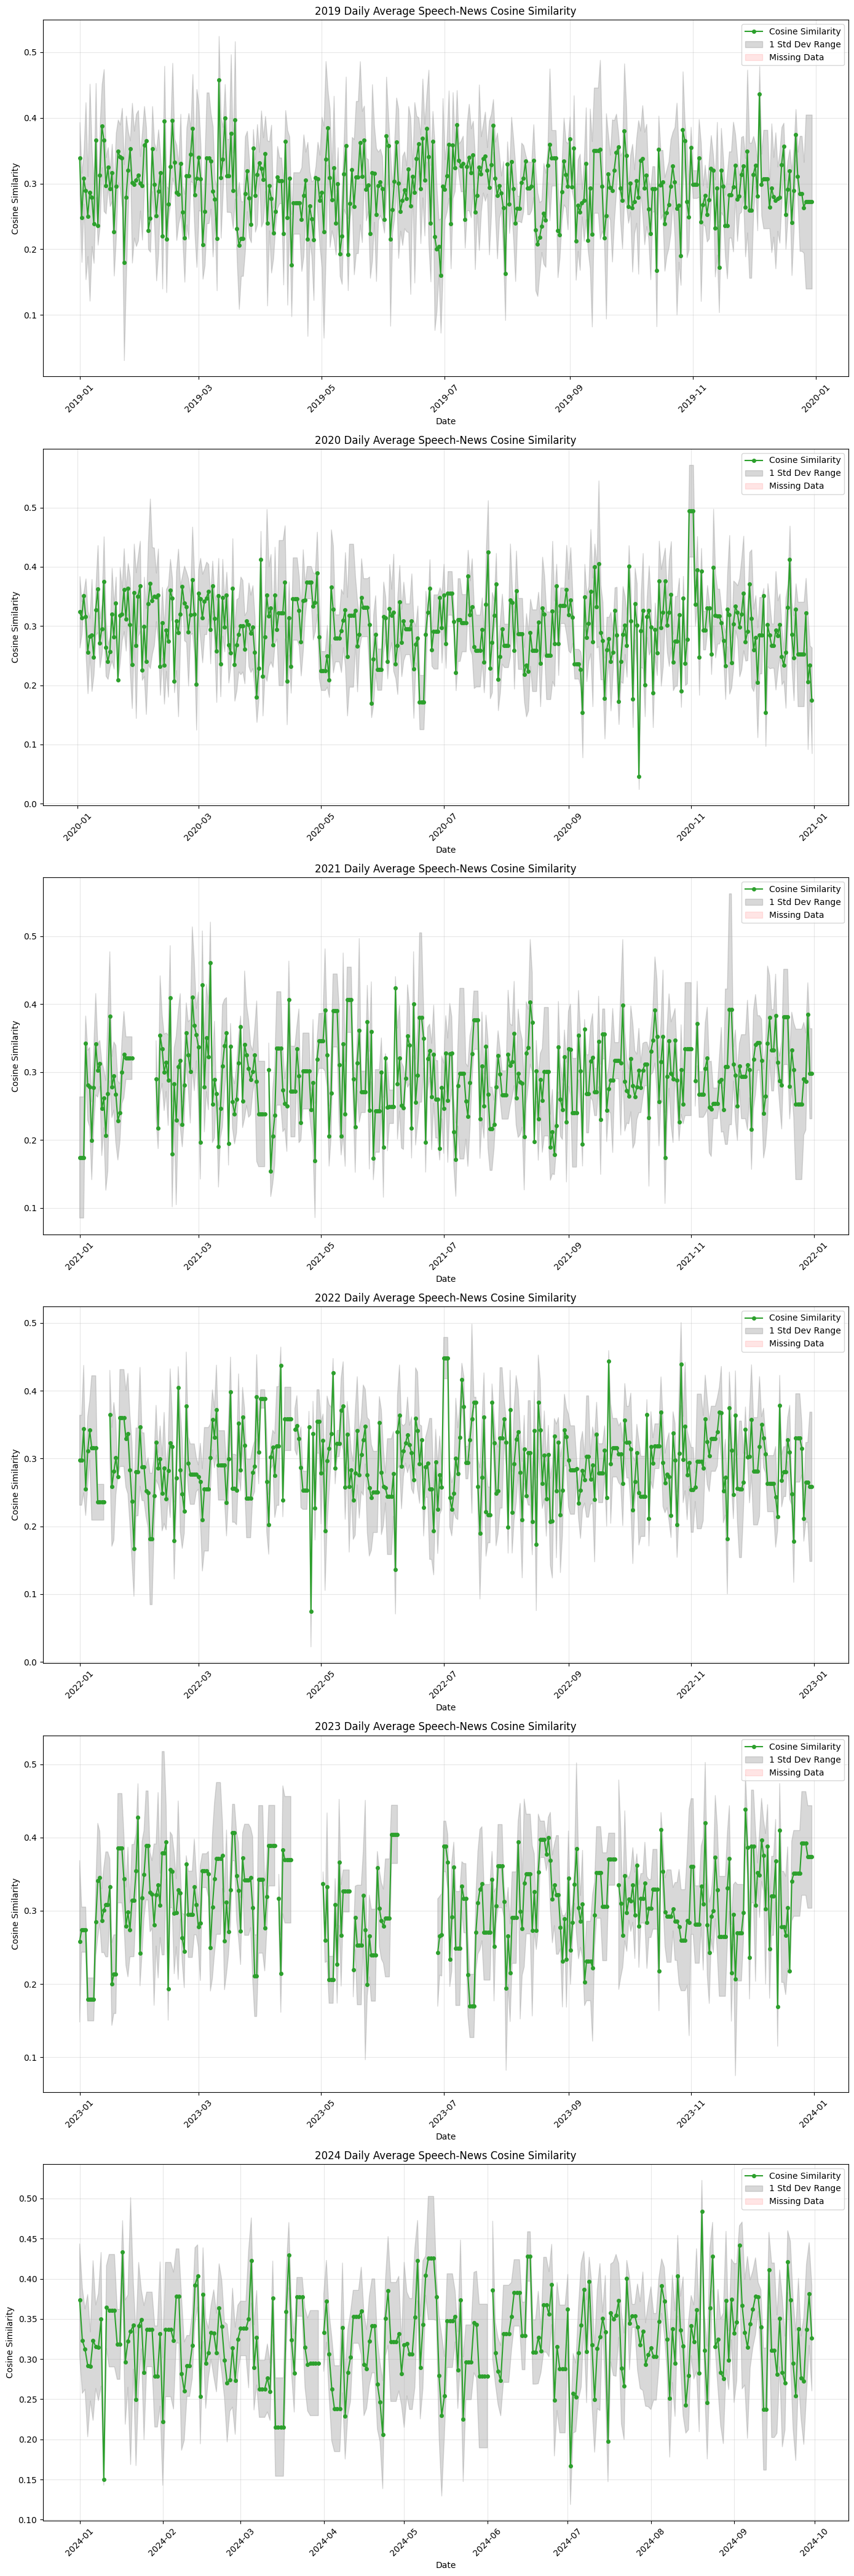

In [3]:
import matplotlib.pyplot as plt

# Define the years to plot
years = range(2019, 2025)

# Set up the figure size
plt.figure(figsize=(14, 7 * len(years)))

for i, year in enumerate(years, 1):
    yearly_df = final_df[final_df['date'].dt.year == year]
    
    if yearly_df.empty:
        continue  # Skip empty years
    
    plt.subplot(len(years), 1, i)  # Create a subplot for each year
    
    plt.plot(yearly_df['date'], 
             yearly_df['cosine_similarity'], 
             color='#2ca02c', 
             linewidth=1.5,
             marker='o',
             markersize=4,
             label='Cosine Similarity')

    # Plot the upper and lower bounds for 1 standard deviation
    plt.fill_between(yearly_df['date'], 
                     yearly_df['upper_bound'], 
                     yearly_df['lower_bound'], 
                     color='gray', alpha=0.3, label='1 Std Dev Range')

    # Highlight missing data in red
    missing_mask = yearly_df['cosine_similarity'].isna()
    plt.fill_between(yearly_df['date'], 
                     yearly_df['cosine_similarity'], 
                     where=missing_mask,
                     color='red', 
                     alpha=0.1,
                     label='Missing Data')

    # Formatting
    plt.title(f'{year} Daily Average Speech-News Cosine Similarity')
    plt.xlabel('Date')
    plt.ylabel('Cosine Similarity')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()


In [7]:
print(speeches_embeddings.columns)
print(news_embeddings.columns)

Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'speech_chunks', 'speech_embeddings'],
      dtype='object')
Index(['Index', 'Link', 'Domain', 'Title', 'Date', 'Content', 'month_abbr',
       'processed_content', 'news_chunks', 'news_embeddings'],
      dtype='object')


# maybe we would also need a regression here before doing topic modelling 

# First we have to try topic modelling and regression 

# Second we can try let's do sentiment analysis. 

Kernel died twice, so I think i'll just load the dataframe containing the news sentiment. 

In [4]:
import os
import time
import torch
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification

# Load the pre-trained SaBERT model and tokenizer
MODEL_NAME = "VerificadoProfesional/SaBERT-Spanish-Sentiment-Analysis"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [5]:
def predict_sentiment(text):
    """Predicts sentiment for a given text using SaBERT."""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    return "Positive" if predicted_class == 1 else "Negative"

def process_with_progress(df, chunk_column, sentiment_column, update_interval=10_000):
    """
    Processes sentiment analysis for a dataset with a tqdm progress bar.
    Prints status updates only every `update_interval` rows.
    """
    start_time = time.time()
    total_chunks = len(df)

    # Using tqdm for a clean progress bar
    for idx, row in tqdm(df.iterrows(), total=total_chunks, desc="Analyzing Sentiment", leave=True, dynamic_ncols=True):
        df.at[idx, sentiment_column] = predict_sentiment(row[chunk_column])

        # Print status update every `update_interval` rows
        if (idx + 1) % update_interval == 0 or (idx + 1) == total_chunks:
            elapsed_time = time.time() - start_time
            avg_time_per_chunk = elapsed_time / (idx + 1)
            estimated_time_left = (total_chunks - (idx + 1)) * avg_time_per_chunk
            print(f"\n[INFO] Processed {idx + 1}/{total_chunks} chunks. "
                  f"Elapsed Time: {elapsed_time:.2f}s. Estimated Time Left: {estimated_time_left:.2f}s.")

    total_time = time.time() - start_time
    print(f"\n✅ Processing complete! Total time: {total_time:.2f} seconds.")
    return df

In [6]:
# Run sentiment analysis for speech and news embeddings
speeches_embeddings = process_with_progress(speeches_embeddings, 'speech_chunks', 'speech_sentiment')

Analyzing Sentiment:   6%|▌         | 10013/174818 [01:54<31:34, 87.01it/s]


[INFO] Processed 10000/174818 chunks. Elapsed Time: 114.30s. Estimated Time Left: 1883.93s.


Analyzing Sentiment:  11%|█▏        | 20010/174818 [03:47<29:33, 87.27it/s]


[INFO] Processed 20000/174818 chunks. Elapsed Time: 227.23s. Estimated Time Left: 1758.93s.


Analyzing Sentiment:  17%|█▋        | 30010/174818 [05:41<26:44, 90.23it/s]


[INFO] Processed 30000/174818 chunks. Elapsed Time: 341.06s. Estimated Time Left: 1646.37s.


Analyzing Sentiment:  23%|██▎       | 40012/174818 [07:35<25:50, 86.96it/s]


[INFO] Processed 40000/174818 chunks. Elapsed Time: 454.88s. Estimated Time Left: 1533.17s.


Analyzing Sentiment:  29%|██▊       | 50013/174818 [09:29<23:07, 89.95it/s]


[INFO] Processed 50000/174818 chunks. Elapsed Time: 568.99s. Estimated Time Left: 1420.41s.


Analyzing Sentiment:  34%|███▍      | 60009/174818 [11:22<21:18, 89.82it/s]


[INFO] Processed 60000/174818 chunks. Elapsed Time: 682.85s. Estimated Time Left: 1306.73s.


Analyzing Sentiment:  40%|████      | 70013/174818 [13:18<20:26, 85.45it/s]


[INFO] Processed 70000/174818 chunks. Elapsed Time: 798.48s. Estimated Time Left: 1195.65s.


Analyzing Sentiment:  46%|████▌     | 80010/174818 [15:14<17:55, 88.16it/s]


[INFO] Processed 80000/174818 chunks. Elapsed Time: 914.47s. Estimated Time Left: 1083.85s.


Analyzing Sentiment:  51%|█████▏    | 90009/174818 [17:09<16:16, 86.81it/s]


[INFO] Processed 90000/174818 chunks. Elapsed Time: 1029.66s. Estimated Time Left: 970.38s.


Analyzing Sentiment:  57%|█████▋    | 100015/174818 [19:05<14:10, 87.97it/s]


[INFO] Processed 100000/174818 chunks. Elapsed Time: 1145.01s. Estimated Time Left: 856.68s.


Analyzing Sentiment:  63%|██████▎   | 110011/174818 [21:00<12:07, 89.12it/s]


[INFO] Processed 110000/174818 chunks. Elapsed Time: 1260.45s. Estimated Time Left: 742.73s.


Analyzing Sentiment:  69%|██████▊   | 120011/174818 [22:53<10:05, 90.58it/s]


[INFO] Processed 120000/174818 chunks. Elapsed Time: 1373.60s. Estimated Time Left: 627.48s.


Analyzing Sentiment:  74%|███████▍  | 130010/174818 [24:46<08:26, 88.54it/s]


[INFO] Processed 130000/174818 chunks. Elapsed Time: 1486.73s. Estimated Time Left: 512.56s.


Analyzing Sentiment:  80%|████████  | 140011/174818 [26:38<06:25, 90.36it/s]


[INFO] Processed 140000/174818 chunks. Elapsed Time: 1598.23s. Estimated Time Left: 397.48s.


Analyzing Sentiment:  86%|████████▌ | 150016/174818 [28:29<04:50, 85.39it/s]


[INFO] Processed 150000/174818 chunks. Elapsed Time: 1709.47s. Estimated Time Left: 282.84s.


Analyzing Sentiment:  92%|█████████▏| 160011/174818 [30:22<02:46, 89.20it/s]


[INFO] Processed 160000/174818 chunks. Elapsed Time: 1822.42s. Estimated Time Left: 168.78s.


Analyzing Sentiment:  97%|█████████▋| 170015/174818 [32:15<00:56, 85.05it/s]


[INFO] Processed 170000/174818 chunks. Elapsed Time: 1935.80s. Estimated Time Left: 54.86s.


Analyzing Sentiment: 100%|██████████| 174818/174818 [33:10<00:00, 87.85it/s]


[INFO] Processed 174818/174818 chunks. Elapsed Time: 1990.02s. Estimated Time Left: 0.00s.

✅ Processing complete! Total time: 1990.02 seconds.


In [7]:
news_embeddings = process_with_progress(news_embeddings, 'news_chunks', 'news_sentiment')

Analyzing Sentiment:  23%|██▎       | 10010/42822 [03:00<09:09, 59.74it/s]


[INFO] Processed 10000/42822 chunks. Elapsed Time: 179.83s. Estimated Time Left: 590.24s.


Analyzing Sentiment:  47%|████▋     | 20010/42822 [06:06<06:41, 56.79it/s]  


[INFO] Processed 20000/42822 chunks. Elapsed Time: 366.02s. Estimated Time Left: 417.66s.


Analyzing Sentiment:  70%|███████   | 30008/42822 [08:59<05:00, 42.59it/s]


[INFO] Processed 30000/42822 chunks. Elapsed Time: 539.44s. Estimated Time Left: 230.56s.


Analyzing Sentiment:  93%|█████████▎| 40008/42822 [11:51<00:48, 58.43it/s]


[INFO] Processed 40000/42822 chunks. Elapsed Time: 711.26s. Estimated Time Left: 50.18s.


Analyzing Sentiment: 100%|██████████| 42822/42822 [12:43<00:00, 56.07it/s]


[INFO] Processed 42822/42822 chunks. Elapsed Time: 763.74s. Estimated Time Left: 0.00s.

✅ Processing complete! Total time: 763.74 seconds.


In [14]:
# Rename 'Date' to 'date' in news_data
news_data = news_data.rename(columns={'Date': 'date'})

# Now merge
news_final_df = news_data.merge(final_df, on='date', how='left')


In [15]:
print("News Data Columns:", news_data.columns)
print("Final DF Columns:", final_df.columns)


News Data Columns: Index(['Index', 'Link', 'Domain', 'Title', 'date', 'Content', 'month_abbr',
       'processed_content', 'news_chunks', 'news_embeddings',
       'news_sentiment_x', 'news_sentiment_y'],
      dtype='object')
Final DF Columns: Index(['date', 'cosine_similarity', 'std_dev', 'upper_bound', 'lower_bound'], dtype='object')


In [ ]:
news_data = news_data.merge(
    news_embeddings[['Index', 'news_sentiment']], 
    on='Index', 
    how='left'
)
news_final_df = news_data.merge(final_df, on='Date', how='left')



In [33]:
news_final_df = news_final_df[['date', 'news_chunks', 'news_sentiment', 
                               'cosine_similarity', 'std_dev', 
                               'upper_bound', 'lower_bound', 'Link']]


In [12]:
# Save speeches_embeddings with speech_sentiment
speeches_embeddings.to_csv("speeches_embeddings_with_sentiment.csv", index=False)


In [34]:
# Ensure 'date' is datetime type before merging
speeches_data['date'] = pd.to_datetime(speeches_data['date'])
news_data['date'] = pd.to_datetime(news_data['Date'])  # Align column names

# Merge speeches and news data
merged_df = speeches_data.merge(news_data, on='date', suffixes=('_speech', '_news'))

# Merge with final_df containing cosine similarity results
merged_df = merged_df.merge(final_df, on='date', how='left')


In [37]:
print("Speeches Embeddings Columns:", speeches_embeddings.columns)
print("News Embeddings Columns:", news_embeddings.columns)


Speeches Embeddings Columns: Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'speech_chunks', 'speech_embeddings', 'speech_sentiment'],
      dtype='object')
News Embeddings Columns: Index(['Index', 'Link', 'Domain', 'Title', 'Date', 'Content', 'month_abbr',
       'processed_content', 'news_chunks', 'news_embeddings',
       'news_sentiment'],
      dtype='object')


In [36]:
print("Speeches Data Columns:", speeches_data.columns)
print("News Data Columns:", news_data.columns)


Speeches Data Columns: Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'speech_chunks', 'speech_embeddings'],
      dtype='object')
News Data Columns: Index(['Index', 'Link', 'Domain', 'Title', 'Date', 'Content', 'month_abbr',
       'processed_content', 'news_chunks', 'news_embeddings', 'date'],
      dtype='object')


In [ ]:
# Merge sentiment scores into the main DataFrames
speeches_data = speeches_data.merge(
    speeches_embeddings[['speech_id', 'speech_sentiment']], 
    on='speech_id', 
    how='left'
)

news_data = news_data.merge(
    news_embeddings[['Index', 'news_sentiment']], 
    on='Index', 
    how='left'
)

# Merge all data
merged_df = speeches_data.merge(news_data, on='date', suffixes=('_speech', '_news'))
merged_df = merged_df.merge(final_df, on='date')

# Select only relevant columns
final_df = merged_df[['date', 'speech_chunks', 'speech_sentiment', 'news_chunks', 
                      'news_sentiment', 'cosine_similarity', 'std_dev', 
                      'upper_bound', 'lower_bound', 'urls']]

In [ ]:
# =====================================================================
# 9. Time-Series Regression Model
# =====================================================================
import statsmodels.api as sm
from linearmodels import PanelOLS

# Create temporal features
regression_df['day_of_week'] = regression_df['date'].dt.dayofweek
regression_df['time_trend'] = np.arange(len(regression_df))

# Lagged similarity (t-1)
regression_df['lagged_similarity'] = regression_df['cosine_similarity'].shift(1)

# Speech occurrence indicator
regression_df['speech_occurred'] = regression_df['date'].isin(speeches_data['date']).astype(int)

# Prepare formula
topic_terms = ' + '.join([f'speech_topic_{i}' for i in range(20)])
formula = f'''
cosine_similarity ~ 
    speech_occurred +
    {topic_terms} +
    news_topic_0 + news_topic_1 + news_topic_2 +  # Select key news topics
    lagged_similarity +
    C(day_of_week) + 
    time_trend
'''

# Fit model with HAC standard errors
model = sm.OLS.from_formula(
    formula, 
    data=regression_df.dropna()
).fit(
    cov_type='HAC',
    cov_kwds={'maxlags': 3},
    use_t=True
)


In [8]:
# Initialize GPU-accelerated models
umap_model = UMAP(n_components=5, n_neighbors=15, metric='cosine', random_state=42)
cluster_model = KMeans(n_clusters=20, random_state=42)

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=cluster_model,  # Using cuML's KMeans instead of HDBSCAN
    verbose=True
)

# Convert embeddings to cuML-compatible format (PyTorch GPU -> cuDF)
import cudf
from cuml.preprocessing import normalize

# Process speeches
speech_embeddings_gpu = cudf.DataFrame(
    speeches_embeddings['speech_embeddings'].apply(
        lambda x: cudf.Series(np.fromstring(x.strip("[]"), sep=" "))
speech_embeddings_gpu = normalize(speech_embeddings_gpu).values  # L2 normalization on GPU

speech_topics, _ = topic_model.fit_transform(
    speeches_embeddings['content'].tolist(), 
    embeddings=speech_embeddings_gpu
)

# Process news
news_embeddings_gpu = cudf.DataFrame(
    news_embeddings['news_embeddings'].apply(
        lambda x: cudf.Series(np.fromstring(x.strip("[]"), sep=" ")))
news_embeddings_gpu = normalize(news_embeddings_gpu).values

news_topics, _ = topic_model.transform(
    news_embeddings['Content'].tolist(),
    embeddings=news_embeddings_gpu
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-8-95611527ba79>, line 18)

In [ ]:
# =====================================================================
# 10. Diagnostics & Visualization
# =====================================================================
print(model.summary())

# Plot significant coefficients
significant_results = model.params[model.pvalues < 0.05]
plt.figure(figsize=(10, 6))
significant_results.plot(kind='barh')
plt.title('Significant Predictors of Media-Speech Alignment')
plt.xlabel('Coefficient Size')
plt.ylabel('Predictors')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save model results
with open('regression_results.txt', 'w') as f:
    f.write(str(model.summary()))